In [3]:
# Устанавливаем необходимые пакеты (если они еще не установлены)
#install.packages(c("tidyverse", "pls", "caret"))

# Подключаем необходимые библиотеки
if (!requireNamespace("lars", quietly = TRUE)) {
  install.packages("lars")
}
if (!requireNamespace("olsrr", quietly = TRUE)) {
  install.packages("olsrr")
}
library(lars)  # Подключение пакета для работы с методом LARS
library(olsrr) # Подключение пакета для работы с методом ols_step_best_subset

library(tidyverse)
library(pls)
library(caret)
library(ggplot2)  # Подключение пакета для построения графиков
library(gridExtra) # Подключение пакета для объединения графиков
library(ggpubr)


Loaded lars 1.3



Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:pls’:

    R2


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘gridExtra’


The following object is masked from 

Описание использования загруженных пакетов:
* `library(ggplot2)` - используется в методе `plot(model)` класса `CLASS`, для построения требуемых граффиков
* `library(gridExtra) ` - используется в методе `plot(model)` класса `CLASS`, для объединенного вывода граффиков

# Реализация класса

In [ ]:
methods('plot')
?plot.function 

In [1]:
summary <- function(x, ...) UseMethod("summary")

summary.CLASS <- function(x, ...){
    print("--- IN summary.CLASS")
    class(x) <- class(x)[class(x) != 'CLASS']
    NextMethod()
}

summary.default <- function(x, ...) {  
    cat("\t\t","--- OVERWRITED summary.default ")
    if(class(x) == 'lm'){
        cat("for 'lm' ","---\n\n")
        # Вывод результатов
        print(summary.lm(x, ...))
        cat("\tКоэффициент детерминации (R^2):", attributes(x)$r_squared, "\n")
        cat("\tИнформационный критерий Акаике (AIC):", attributes(x)$aic, "\n")
        cat("\tСкорректированный коэффициент детерминации:", attributes(x)$adj_r_squared, ".\n")
        cat("\tНаиболее значимая переменная по критерию Стюдента:", attributes(x)$most_sign_var, "\n")
        cat("\tНаименее значимая переменная по критерию Стюдента:", attributes(x)$least_sign_var, "\n")
    }
    
}

In [2]:
fit <- function(x, ...) UseMethod("fit")

fit.data.frame <- function(train_data, step=1){
    print("--- IN fit.data.frame")
    if(step==1){
        model <- lm(MPG_Highway ~ ., data=train_data)
        # Оценка коэффициента детерминации ("R^2")
        r_squared <- summary.lm(model)$r.squared

        # Оценка информационного критерия Акаике (AIC)
        aic <- AIC(model)

        # Оценка скорректированного коэффициента детерминации
        n <- nrow(data)
        p <- length(coefficients(model)) - 1
        adj_r_squared <- 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
                
        # Вывод наиболее и наименее значимых переменных по критерию Стюдента
        coefs <- summary.lm(model)$coefficients
        significant_vars <- coefs[coefs[, "Pr(>|t|)"] < 0.05, ]
        max_sig <- which.min(significant_vars[, "Pr(>|t|)"])
        min_sig <- which.max(coefs[, "Pr(>|t|)"])
        #most_significant <- significant_vars[max_sig, ]
        #least_significant <- significant_vars[min_sig, ]
        most_sign_var <- rownames(significant_vars)[max_sig]
        least_sign_var <- rownames(coefs)[min_sig]

        class(model) <- c(class(model),"CLASS")
        attr(model, "r_squared") <- round(r_squared, 3)
        attr(model, "aic") <- round(aic, 3)
        attr(model, "adj_r_squared") <- round(adj_r_squared, 3)
        attr(model, "most_sign_var") <- most_sign_var
        attr(model, "least_sign_var") <- least_sign_var
        attr(model, "cookd") <- NA
        #try({attr(model, "cookd") <- cookd}, silent = T)
        return(model)
    }
    
}

In [4]:
plot <- function(x, ...) UseMethod("plot")

plot.CLASS <- function(x, ...){
    cat("\t--- IN plot.CLASS")
    class(x) <- class(x)[class(x) != 'CLASS']
    NextMethod()
}

plot.default <- function(x, ...) {  
    cat("\t\t","--- OVERWRITED plot.default ")
    if(class(x) == 'lm'){
        cat("for 'lm' ","---\n\n")

        # Графики зависимости остатков от прогноза
        df <- data.frame(fitted=x$fitted.values, resid=x$residuals)
        plot_residuals <- ggplot(data = df, aes(x = fitted, y = resid)) +
              geom_point() +
              labs(x = "Прогноз", y = "Остатки", title = "Зависимость остатков от прогноза") +
              geom_hline(yintercept = 0, color = "red")

        # Гистограмма остатков
        hist_residuals <- ggplot(data = df, aes(x = resid)) +
              geom_histogram(binwidth = 2, fill = "lightgrey", color = "black") +
              labs(x = "Остатки", y = "Частота", title = "Гистограмма распределения остатков")
        
        if(!all(is.na(attributes(x)$cookd))){
            cat("\t ONLY CookD statistic\n\n\n")
            cookd_data <- data.frame(Наблюдение = 1:length(attributes(x)$cookd),
                                     Cooks_distance = attributes(x)$cookd)
            # Строим график Cook's distance
            plot_cookd <- ggplot(cookd_data, aes(x = Наблюдение, y = Cooks_distance)) +
              geom_point(shape = 20) +
              labs(title = "График Cook's distance", x = "Наблюдение", y = "Cook's distance") +
              geom_point(data = cookd_data[top_outliers, ], 
                         aes(x = Наблюдение, y = Cooks_distance), 
                         color = "red", shape = 20) +
              geom_text(data = cookd_data[top_outliers, ], 
                         aes(x = Наблюдение, y = Cooks_distance, label = Наблюдение), 
                         color = "red", vjust = -0.5)
            
            return(plot_cookd)
        }
        print(hist_residuals)
        cat("\n\n\n")
        print(plot_residuals)
    }
    
}

## Часть 1

[1] "--- IN fit.data.frame"
[1] "--- IN summary.CLASS"
		 --- OVERWRITED summary.default for 'lm'  ---


Call:
lm(formula = MPG_Highway ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.9323 -1.5346 -0.2137  1.4116 14.1034 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.009e+01  3.086e+00  19.475  < 2e-16 ***
Length        2.610e-02  2.040e-02   1.279   0.2015    
Weight       -4.056e-03  4.254e-04  -9.535  < 2e-16 ***
Wheelbase     4.502e-02  3.947e-02   1.141   0.2547    
Horsepower   -1.771e-02  4.420e-03  -4.007 7.29e-05 ***
Invoice       2.642e-02  1.417e-02   1.864   0.0630 .  
EngineSize   -9.612e-02  3.737e-01  -0.257   0.7971    
Cylinders    -4.489e-01  2.095e-01  -2.143   0.0327 *  
OriginEurope  2.706e-01  3.899e-01   0.694   0.4880    
OriginUSA     4.024e-01  3.161e-01   1.273   0.2038    
TypeSedan    -2.200e+01  1.455e+00 -15.126  < 2e-16 ***
TypeSports   -2.341e+01  1.542e+00 -15.181  < 2e-16 ***
Typ

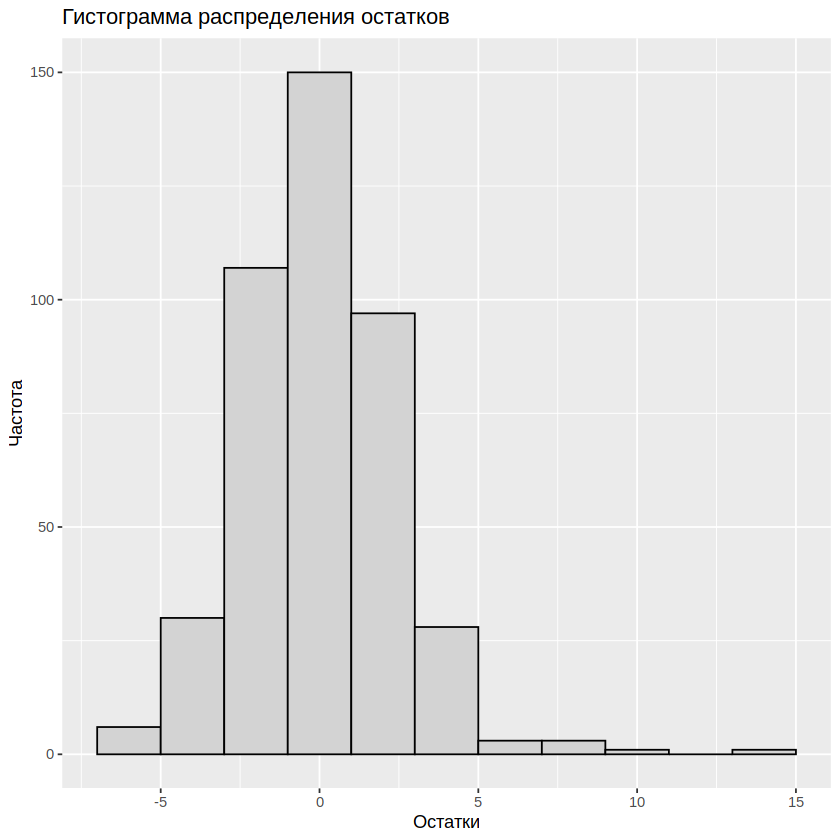

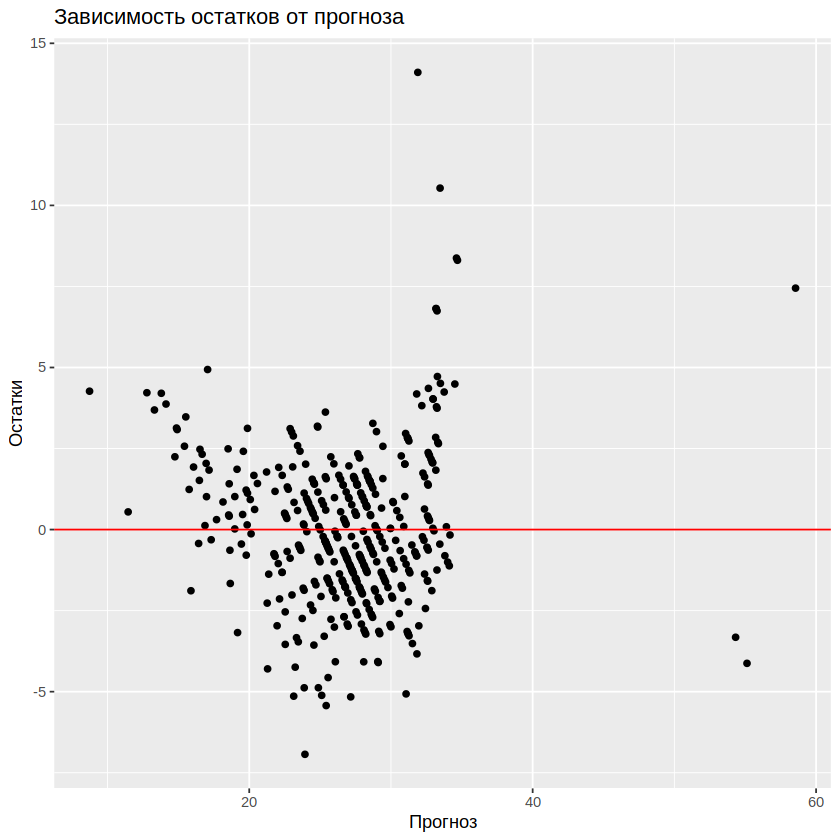

In [5]:
# Установка рабочего каталога, если файл находится в другой директории
setwd("~/Documents/VMK/MaSP/Data")

# Загрузка данных из файла
data <- read.csv("CARS.csv", header=TRUE, sep=",")
data <- data[,c("MPG_Highway", "Length", "Weight", "Wheelbase", "Horsepower", "Invoice", "EngineSize", "Cylinders", "Origin", "Type")]

# Преобразование переменной Invoice в числовой формат
data$Invoice <- as.double(gsub("\\$", "", gsub(",", ".", data$Invoice)))

# Построение регрессии
model <- fit(data)

# Вывод результатов регрессии
summary(model)

# Визуализация результатов регрессии
plot(model)

##### Комментарии:
В Intercept находятся "азиатские гибриды".
При анализе таблице получилось, что наиболее значимой переменной оказалась Type, а наименее EngineSize
Анализ графиков, позволяет заключить, что следующие предположения линейной регрессии выполнены:
1. остатки в своем бовольшинсве распределены нормальным образом (рис. справа),
2. изменчивость остатков довольно симметрична и постояна (рис. слева).

## Часть 2 

Индексы выбросов: 63  67  81  85 119 145 150 151 156 204 217 230 239 251 261 267 272 335 363 374 
 63  67  81  85 119 145 150 151 156 204 217 230 239 249 259 265 270 333 361 372 
383 385 399 400 405 413 
381 383 397 398 403 411 
	--- IN plot.CLASS		 --- OVERWRITED plot.default for 'lm'  ---

	 ONLY CookD statistic




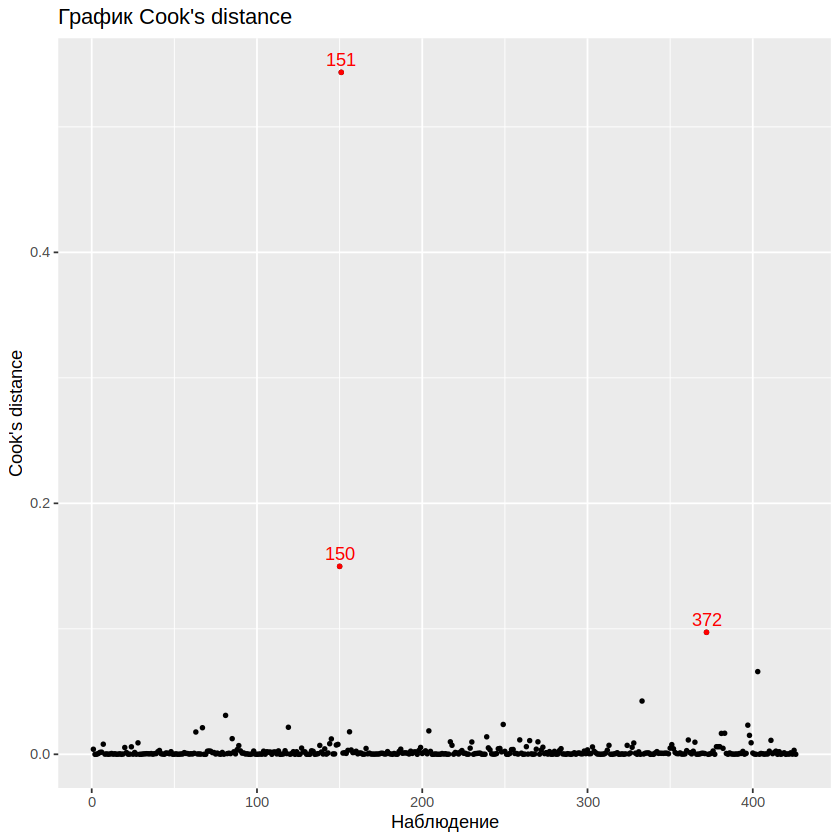

In [6]:
# Рассчитываем статистику Cook's distance
cookd <- cooks.distance(model)
attr(model, "cookd") <- cookd

# Находим выбросы по доверительной области
cooks_cutoff <- 4 / (nrow(data) - length(model$coefficients) - 1)
outliers <- which(cookd > cooks_cutoff)

# Выводим найденные выбросы
cat("Индексы выбросов:")
print(outliers)

# Находим три наиболее аномальных точки
top_outliers <- tail(order(cookd, decreasing = FALSE), 3)

# Исключаем выбросы из данных и три наиболее аномальных точки
cleaned_data <- data[-c(outliers, top_outliers), ]
rownames(cleaned_data) <- 1:nrow(cleaned_data)

plot(model)

[1] "--- IN fit.data.frame"
[1] "--- IN summary.CLASS"
		 --- OVERWRITED summary.default for 'lm'  ---


Call:
lm(formula = MPG_Highway ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.6062 -1.3966 -0.1708  1.3929 13.9933 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.852e+01  3.520e+00  16.627  < 2e-16 ***
Length        3.190e-02  1.971e-02   1.619   0.1063    
Weight       -3.951e-03  4.204e-04  -9.398  < 2e-16 ***
Wheelbase     1.504e-02  3.803e-02   0.395   0.6928    
Horsepower   -1.759e-02  4.187e-03  -4.201 3.30e-05 ***
Invoice       2.249e-02  1.312e-02   1.714   0.0873 .  
EngineSize   -3.534e-02  3.645e-01  -0.097   0.9228    
Cylinders    -4.298e-01  1.978e-01  -2.172   0.0304 *  
OriginEurope  5.010e-01  3.648e-01   1.374   0.1704    
OriginUSA     6.184e-01  2.927e-01   2.113   0.0353 *  
TypeSedan    -1.902e+01  2.230e+00  -8.531 3.34e-16 ***
TypeSports   -2.048e+01  2.295e+00  -8.925  < 2e-16 ***
Typ

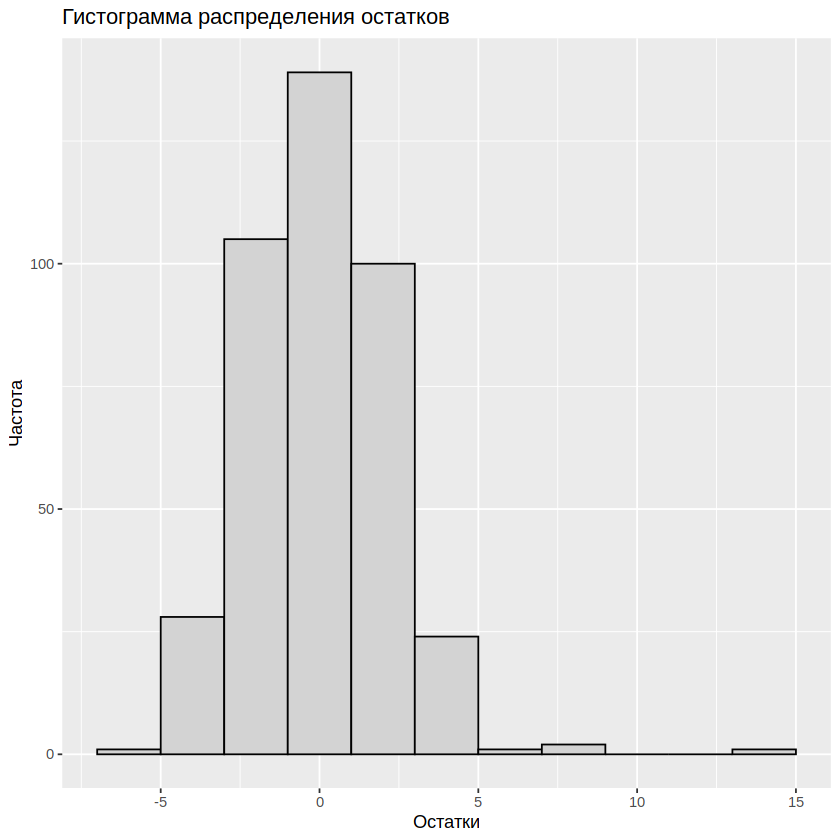

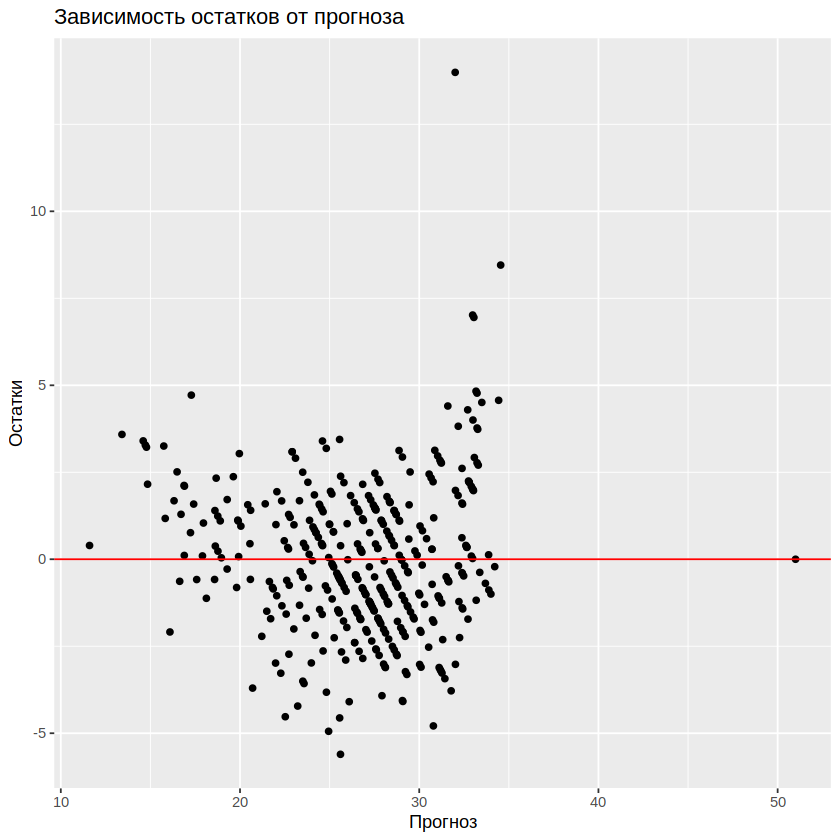

In [7]:
cleaned_model <- fit(cleaned_data)
summary(cleaned_model)
plot(cleaned_model)

	--- IN plot.CLASS		 --- OVERWRITED plot.default for 'lm'  ---

	 ONLY CookD statistic




Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


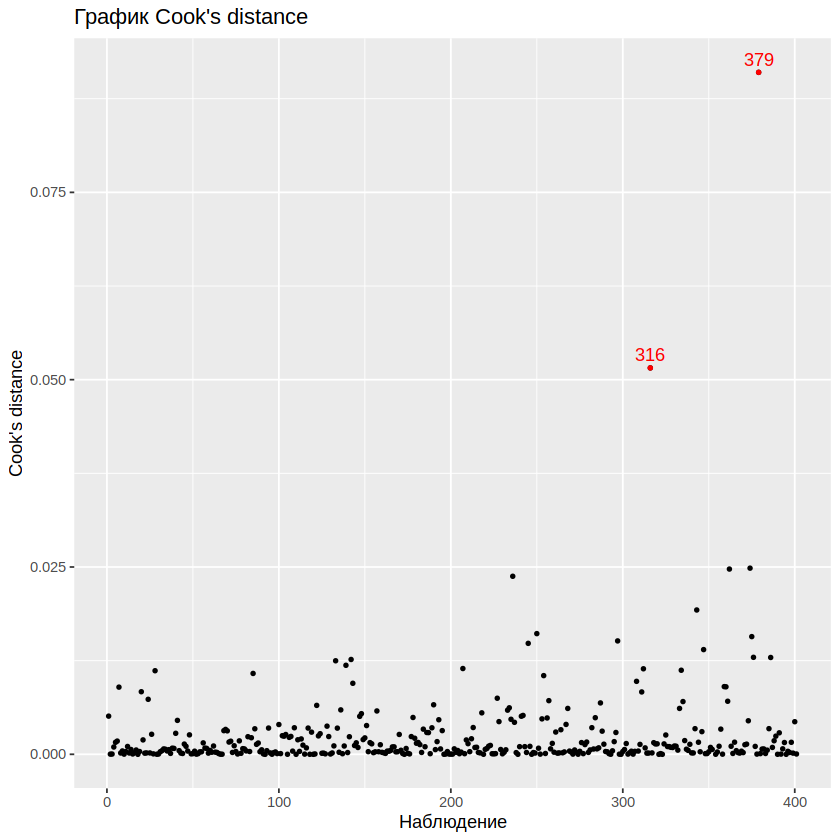

In [8]:
# Рассчитываем статистику Cook's distance
cookd <- cooks.distance(cleaned_model)
attr(cleaned_model, "cookd") <- cooks.distance(cleaned_model)

# Находим три наиболее аномальных точки
top_outliers <- tail(order(cookd, decreasing = FALSE), 3)

plot(cleaned_model)

In [9]:
# Сравнение характеристик моделей

cat("Коэффициенты детерминации (R^2):", "\n", 
    "\tmodel: ", attr(model, 'r_squared'), ", \tcleaned_model:", attr(cleaned_model, 'r_squared'), "\n")
cat("Информационные критерии Акаике (AIC):", "\n", 
    "\tmodel: ", attr(model, 'aic'), ", \tcleaned_model:", attr(cleaned_model, 'aic'), "\n")
cat("Скорректированные коэффициенты детерминации:", "\n", 
    "\tmodel: ", attr(model, 'adj_r_squared'), ", \tcleaned_model:", attr(cleaned_model, 'adj_r_squared'), "\n")


Коэффициенты детерминации (R^2): 
 	model:  0.827 , 	cleaned_model: 0.817 
Информационные критерии Акаике (AIC): 
 	model:  1982.849 , 	cleaned_model: 1787.184 
Скорректированные коэффициенты детерминации: 
 	model:  0.821 , 	cleaned_model: 0.811 


##### Комментарии:
1. $R$ больше в первой модели, чем во второй,
2. $R_{adj}$ больше в первой модели, чем во второй,
3. $AIC$ второй модели меньше.

Так как скорректированные коэф-ы детерминации близки (модели одинаково хорошо предсказывают), осмысленно судить о качестве моделей на основании результатов критерия $AIC$: вторая модель проще первой.

p-значение переменной EngineSize возросло, приблизевшись к 1, что позволяет увереннее судить о ее малой значимости 


## Часть 3

In [10]:
TukeyHSD(x=aov(lm(MPG_Highway ~ Origin + Type, data=cleaned_data)), conf.level=0.95)
#plot(TukeyHSD(x=aov(lm(MPG_Highway ~ Origin + Type, data=cleaned_data)), conf.level=0.95), las=0)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = lm(MPG_Highway ~ Origin + Type, data = cleaned_data))

$Origin
                  diff        lwr         upr     p adj
Europe-Asia -1.5578731 -2.6730382 -0.44270799 0.0031647
USA-Asia    -1.1265312 -2.1861356 -0.06692678 0.0340980
USA-Europe   0.4313419 -0.6994993  1.56218305 0.6422889

$Type
                     diff         lwr        upr     p adj
Sedan-Hybrid  -21.5902013 -32.5322463 -10.648156 0.0000005
Sports-Hybrid -24.5942246 -35.6379349 -13.550514 0.0000000
SUV-Hybrid    -29.5513089 -40.5704502 -18.532167 0.0000000
Truck-Hybrid  -29.2013601 -40.3786569 -18.024063 0.0000000
Wagon-Hybrid  -22.2139935 -33.3148198 -11.113167 0.0000003
Sports-Sedan   -3.0040234  -4.7887960  -1.219251 0.0000301
SUV-Sedan      -7.9611076  -9.5869468  -6.335268 0.0000000
Truck-Sedan    -7.6111589 -10.0918519  -5.130466 0.0000000
Wagon-Sedan    -0.6237922  -2.7333468   1.485762 0.9584414
SUV-Sports     -4.957

Неразличимые группы в переменной Origin:
1. USA-Europe, -

в переменной Type: 

2. Wagon-Sedan,
3. Wagon-Sports,
4. Truck-SUV.

In [11]:
independent_data <- cleaned_data

# Условия для объединения неразличимых уровней в группы 
cond_1<- independent_data$Origin == 'USA' | independent_data$Origin == 'Europe'
cond_2<- independent_data$Type == 'Wagon' | independent_data$Type == 'Sedan'
cond_3<- independent_data$Type == 'Wagon' | independent_data$Type == 'Sports'
cond_4<- independent_data$Type == 'Truck' | independent_data$Type == 'SUV'

# Преобразование неразличимых групп
independent_data$Origin[cond_1] <- "Group1"
independent_data$Type[cond_2] <- "Group2"
independent_data$Type[cond_3] <- "Group3"
independent_data$Type[cond_4] <- "Group4"

In [12]:
TukeyHSD(x=aov(lm(MPG_Highway ~ Origin + Type, data=independent_data)), conf.level=0.95)
#plot(TukeyHSD(x=aov(lm(MPG_Highway ~ Origin + Type, data=cleaned_data4)), conf.level=0.95), las=0)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = lm(MPG_Highway ~ Origin + Type, data = independent_data))

$Origin
                 diff       lwr        upr     p adj
Group1-Asia -1.321824 -2.109515 -0.5341322 0.0010576

$Type
                   diff       lwr       upr     p adj
Group3-Group2 -2.101922 -3.424180 -0.779664 0.0002903
Group4-Group2 -7.802244 -9.110997 -6.493492 0.0000000
Hybrid-Group2 21.590384 11.574469 31.606299 0.0000003
Group4-Group3 -5.700322 -7.332811 -4.067834 0.0000000
Hybrid-Group3 23.692306 13.628969 33.755642 0.0000000
Hybrid-Group4 29.392628 19.331058 39.454199 0.0000000


In [13]:
independent_model <- fit(independent_data)
summary(independent_model)

[1] "--- IN fit.data.frame"
[1] "--- IN summary.CLASS"
		 --- OVERWRITED summary.default for 'lm'  ---


Call:
lm(formula = MPG_Highway ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4797 -1.3909 -0.1154  1.3353 13.6617 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  41.4333280  2.2162223  18.695  < 2e-16 ***
Length        0.0312695  0.0189084   1.654 0.098988 .  
Weight       -0.0034652  0.0003625  -9.559  < 2e-16 ***
Wheelbase    -0.0133425  0.0353796  -0.377 0.706287    
Horsepower   -0.0193938  0.0040539  -4.784 2.44e-06 ***
Invoice       0.0197220  0.0125937   1.566 0.118157    
EngineSize   -0.0740438  0.3198085  -0.232 0.817028    
Cylinders    -0.3992506  0.1932697  -2.066 0.039512 *  
OriginGroup1  0.5431652  0.2496756   2.175 0.030195 *  
TypeGroup3   -1.1461583  0.3423887  -3.348 0.000895 ***
TypeGroup4   -3.6129347  0.3936792  -9.177  < 2e-16 ***
TypeHybrid   18.9912714  2.2436147   8.465 5.30e-16 ***
---

##### Комментарии:
1. Как мы видим до проведения попарных t-тестов и объединения уровней категориальных переменных, имелись статистически одинаковое данные. Однако, группровка позволила выделить статистически различимые выборки.
2. Самое большое значение $R$ принадлежит первой модели,
3. $R_{adj}$ тоже. А $R_{adj}$ оставшихся моделей одинаковы.
4. Наибольшее значение $AIC$ имеет первая модель. У оставшихся моделей значения $AIC$ одинаковы.

Из данных комментариев следует, что разумнее всего использовать последнюю модель.

Наиболее и наименее важные переменные остались прежними.

## Часть 4

In [14]:
to_lars_data <- independent_data

# Проверка на тип переменных
sapply(to_lars_data, class)

# Проверка пропусков
colSums(is.na(to_lars_data))

# Замена недостающих значение в Cylinders
to_lars_data$Cylinders[is.na(to_lars_data$Cylinders)] <- FALSE

# Нумерациа уровней категориальных переменных

to_lars_data$Origin<-(as.numeric(as.factor(to_lars_data$Origin)))
to_lars_data$Type<-(as.numeric(as.factor(to_lars_data$Type)))

# Создание модели
lars_lm <- fit(to_lars_data)

MPG_Highway      Length      Weight   Wheelbase  Horsepower     Invoice 
  "integer"   "integer"   "integer"   "integer"   "integer"   "numeric" 
 EngineSize   Cylinders      Origin        Type 
  "numeric"   "integer" "character" "character"

MPG_Highway      Length      Weight   Wheelbase  Horsepower     Invoice 
          0           0           0           0           0           0 
 EngineSize   Cylinders      Origin        Type 
          0           1           0           0

[1] "--- IN fit.data.frame"


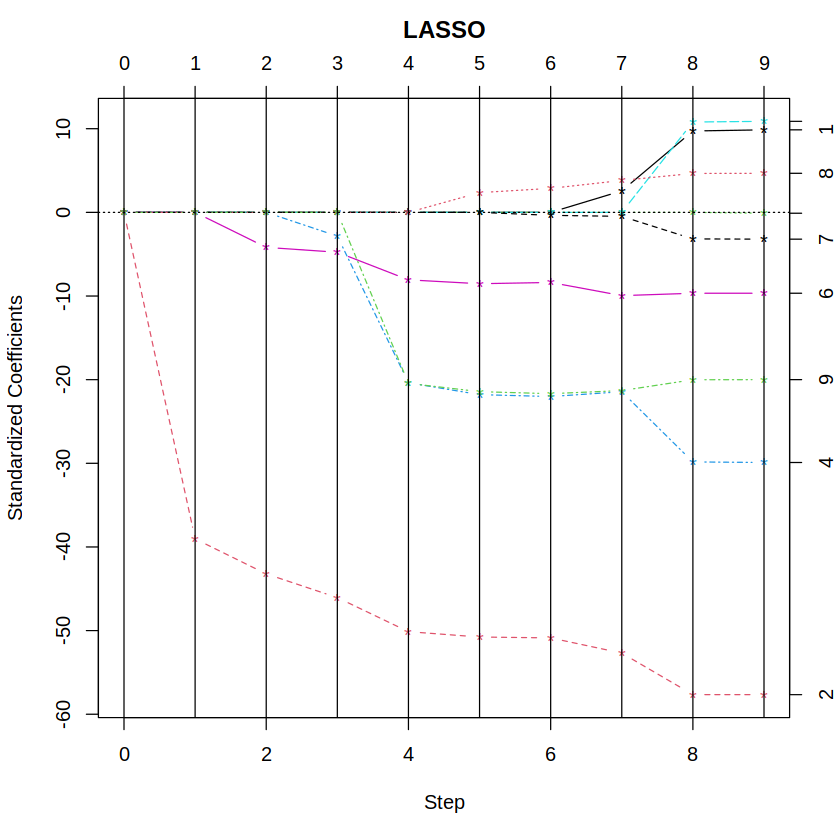

In [15]:
response_variable <- to_lars_data$MPG_Highway
predictor_matrix <- as.matrix(to_lars_data[, c("Length", "Weight", "Wheelbase",
                                                 "Horsepower", "Invoice", "EngineSize", "Cylinders","Origin", "Type")])

lars_model <- lars(predictor_matrix, response_variable, type = "lasso")

# Построение графика трассы коэффициентов
plot.lars(lars_model, xvar='step')

#plot(lars_model$RSS, type='o')

In [16]:
summary(lars_lm)

[1] "--- IN summary.CLASS"
		 --- OVERWRITED summary.default for 'lm'  ---


Call:
lm(formula = MPG_Highway ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3373 -1.4883 -0.1148  1.4258 22.3644 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 41.5107843  2.4636546  16.849  < 2e-16 ***
Length       0.0358654  0.0214510   1.672   0.0953 .  
Weight      -0.0040690  0.0003961 -10.272  < 2e-16 ***
Wheelbase   -0.0006499  0.0393947  -0.016   0.9868    
Horsepower  -0.0209785  0.0044796  -4.683 3.90e-06 ***
Invoice      0.0308326  0.0142241   2.168   0.0308 *  
EngineSize  -0.4518365  0.3602081  -1.254   0.2105    
Cylinders   -0.1024466  0.2095631  -0.489   0.6252    
Origin       0.4826680  0.2819542   1.712   0.0877 .  
Type        -1.2485590  0.2000463  -6.241 1.13e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.519 on 392 degrees of freedom
Multiple R-squared:  0.757,	A

In [17]:
model4 <- lm(MPG_Highway ~ ., data=to_lars_data)

k <- ols_step_best_subset(model4, metric="AIC")


In [18]:
plot.ols_step_best_subset(k)

ERROR: Error in plot.ols_step_best_subset(k): could not find function "plot.ols_step_best_subset"


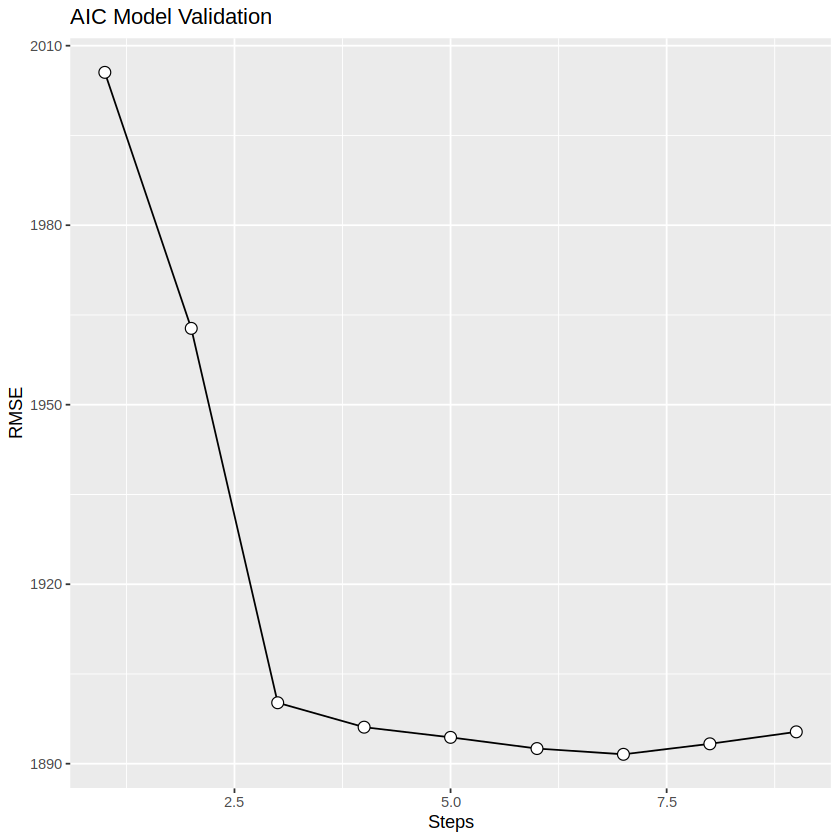

In [25]:
# Create a dataframe for plotting
plot_data <- data.frame(Step = k$n, RMSE = k$aic)

# Create a line plot
ggplot(plot_data, aes(x = Step, y = RMSE)) +
  geom_line() +
  geom_point(shape = 21, size = 3, fill = "white") +
  labs(x = "Steps", y = "RMSE", title = "AIC Model Validation")

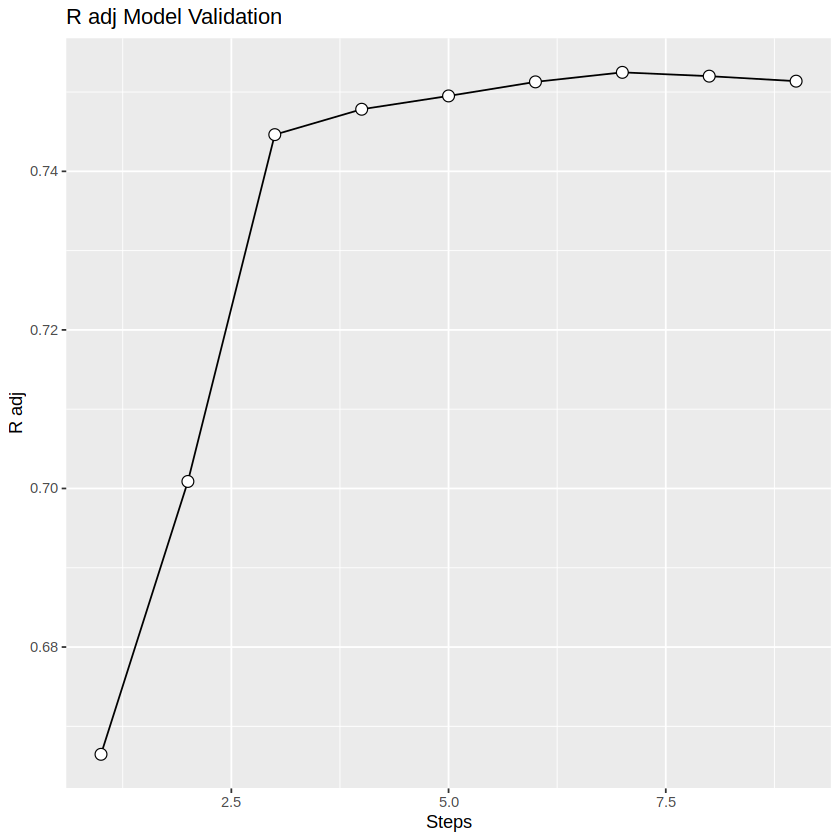

In [26]:
# Create a dataframe for plotting
plot_data <- data.frame(Step = k$n, adj_r = k$adjr)

# Create a line plot
ggplot(plot_data, aes(x = Step, y = adj_r)) +
  geom_line() +
  geom_point(shape = 21, size = 3, fill = "white") +
  labs(x = "Steps", y = "R adj", title = "R adj Model Validation")

In [23]:
k

,mindex,n,predictors,rsquare,adjr,predrsq,cp,aic,sbic,sbc,msep,fpe,apc,hsp
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,1,1,Weight,0.6673024,0.6664706,0.6638828,138.588978,2005.542,863.5865,2017.532,3420.521,8.551091,0.3360246,0.02132521
19,2,2,Weight Horsepower,0.7023771,0.7008853,0.6978370,84.018884,1962.757,820.9020,1978.742,3067.600,7.687743,0.3020984,0.01917286
84,3,3,Weight Horsepower Type,0.7465384,0.7446279,0.7375531,14.793731,1900.189,759.2294,1920.172,2619.010,6.579692,0.2585563,0.01641025
204,4,4,Weight Horsepower Invoice Type,0.7503450,0.7478296,0.7401624,10.654270,1896.106,755.2634,1920.085,2586.191,6.513203,0.2559436,0.01624542
274,5,5,Length Weight Horsepower Invoice Type,0.7526328,0.7495095,0.7404605,8.964415,1894.405,753.6700,1922.381,2568.979,6.485710,0.2548632,0.01617806
404,6,6,Length Weight Horsepower Invoice EngineSize Type,0.7550033,0.7512818,0.7416632,7.141123,1892.534,751.9503,1924.506,2550.818,6.455604,0.2536801,0.01610436
483,7,7,Length Weight Horsepower Invoice EngineSize Origin Type,0.7568027,0.7524819,0.7424886,6.238996,1891.571,751.1414,1927.539,2538.526,6.440162,0.2530733,0.01606743
508,8,8,Length Weight Horsepower Invoice EngineSize Cylinders Origin Type,0.7569507,0.7520031,0.7402991,8.000272,1893.326,752.9576,1933.291,2543.453,6.468358,0.2541813,0.01613958
511,9,9,Length Weight Wheelbase Horsepower Invoice EngineSize Cylinders Origin Type,0.7569509,0.7513707,0.7385853,10.000000,1895.326,755.0084,1939.287,2549.956,6.500633,0.2554496,0.01622212


In [ ]:
methods(plot)

In [ ]:
plot(k)

In [27]:
k[c('rsquare', 'adjr', 'aic')]
cat("Мнимальный AIC: ", min(k$aic), "- на шаге №", which(k$aic == min(k$aic))[1], '\n')
cat("Максимальный скор. коэф. дет.: ", max(k$rsquare), '\n')
cat("Максимальный коэф. дет.: ", max(k$adjr), '\n')

,rsquare,adjr,aic
,<dbl>,<dbl>,<dbl>
2,0.6673024,0.6664706,2005.542
19,0.7023771,0.7008853,1962.757
84,0.7465384,0.7446279,1900.189
204,0.7503450,0.7478296,1896.106
274,0.7526328,0.7495095,1894.405
404,0.7550033,0.7512818,1892.534
483,0.7568027,0.7524819,1891.571
508,0.7569507,0.7520031,1893.326
511,0.7569509,0.7513707,1895.326


Мнимальный AIC:  1891.571 - на шаге № 7 
Максимальный скор. коэф. дет.:  0.7569509 
Максимальный коэф. дет.:  0.7524819 


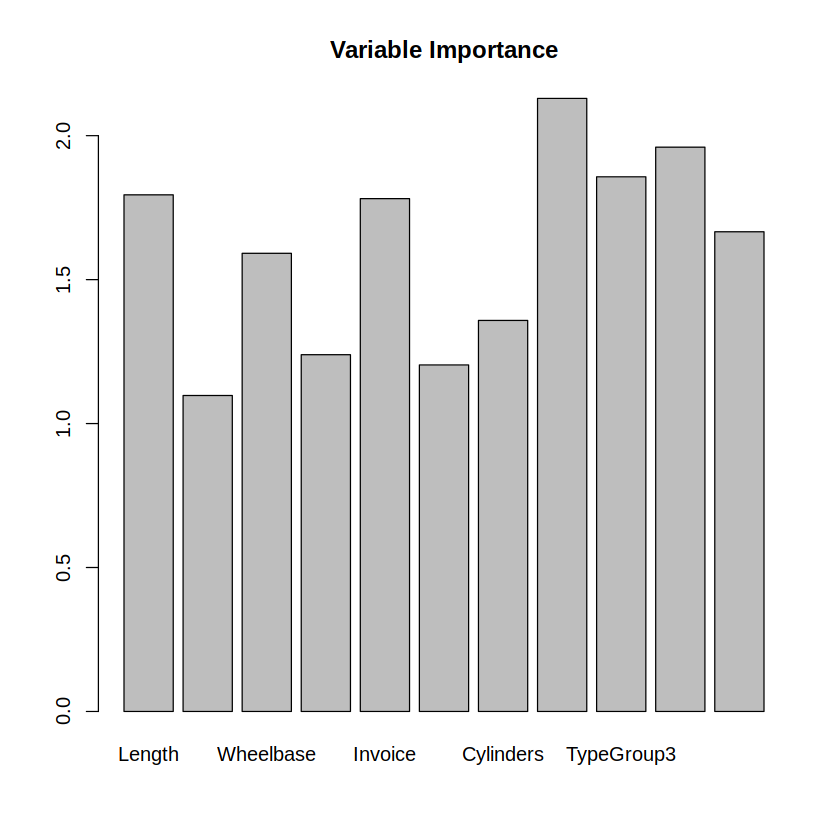

In [28]:
mod_pcr <- pcr(MPG_Highway ~ ., ncomp = 7,
              scale=T, data=independent_data)
barplot(rowSums(abs(mod_pcr$projection)), main='Variable Importance')

##### Комментарии:
1. По всем показателям видо заметное ухудщение.
2. Лучшей моделью оказалась на 7 шаге


## Часть 5

In [20]:
#response_variable <- cleaned_data3$MPG_Highway
#predictor_matrix <- as.matrix(cleaned_data3[, c("Length", "Weight", "Wheelbase", "Horsepower", "Invoice", "EngineSize", "Cylinders","Origin", "Type")])

# Подготовка данных для использования в модели PCR
scaled_data <- scale(predictor_matrix)

# Проведение серии регрессий PCR, перебирая все возможные числа компонент
num_components <- 1:ncol(predictor_matrix)  # Перебираем все возможные числа компонент
pcr_models <- lapply(num_components, function(k) plsr(response_variable ~ ., ncomp = k, 
                                                      data = as.data.frame(scaled_data)))
                          
# Извлечение RMSE для каждой модели
validation_rmse <- sapply(pcr_models, 
                          function(model) sqrt(mean((response_variable - predict(model, as.data.frame(scaled_data)))^2)))

# Преобразование в числовой тип
num_components <- as.numeric(num_components)
validation_rmse <- as.numeric(validation_rmse)


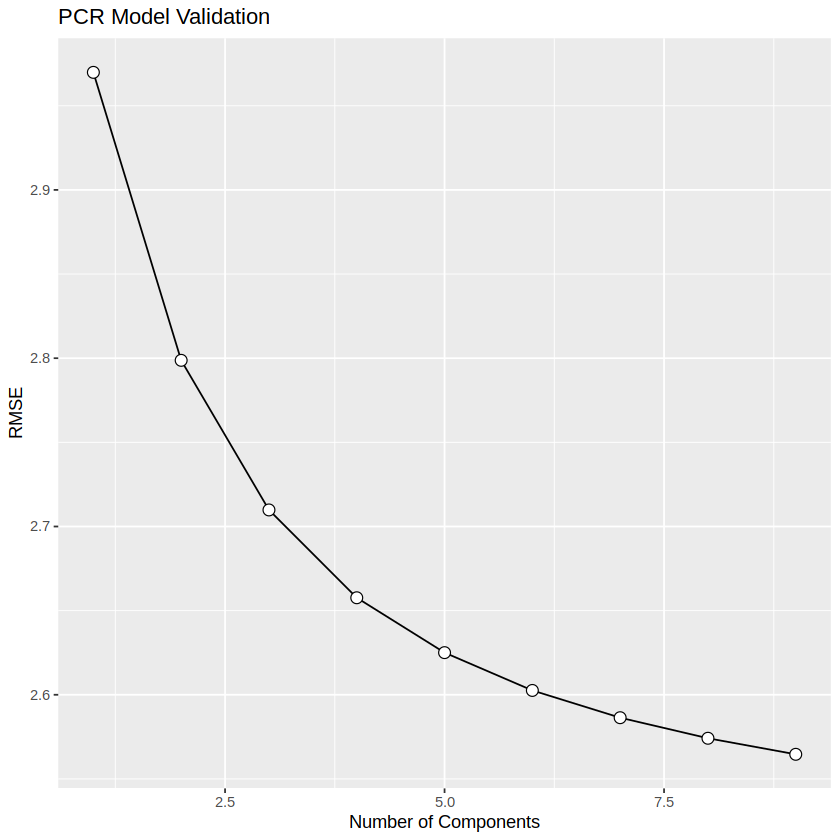

In [21]:
# Create a dataframe for plotting
plot_data <- data.frame(Number_of_Components = num_components, RMSE = validation_rmse)

# Create a line plot
ggplot(plot_data, aes(x = Number_of_Components, y = RMSE)) +
  geom_line() +
  geom_point(shape = 21, size = 3, fill = "white") +
  labs(x = "Number of Components", y = "RMSE", title = "PCR Model Validation")

In [29]:
# Выбор оптимального числа компонент
best_num_components <- which.min(validation_rmse)
best_model <- pcr_models[[best_num_components]]

# Вывод оптимального числа компонент и соответствующего RMSE
cat("Оптимальное количество компонентов: ", best_num_components, "\n")
cat("Соответсвующее RMSE: ", validation_rmse[best_num_components], "\n")

Оптимальное количество компонентов:  9 
Соответсвующее RMSE:  2.564623 


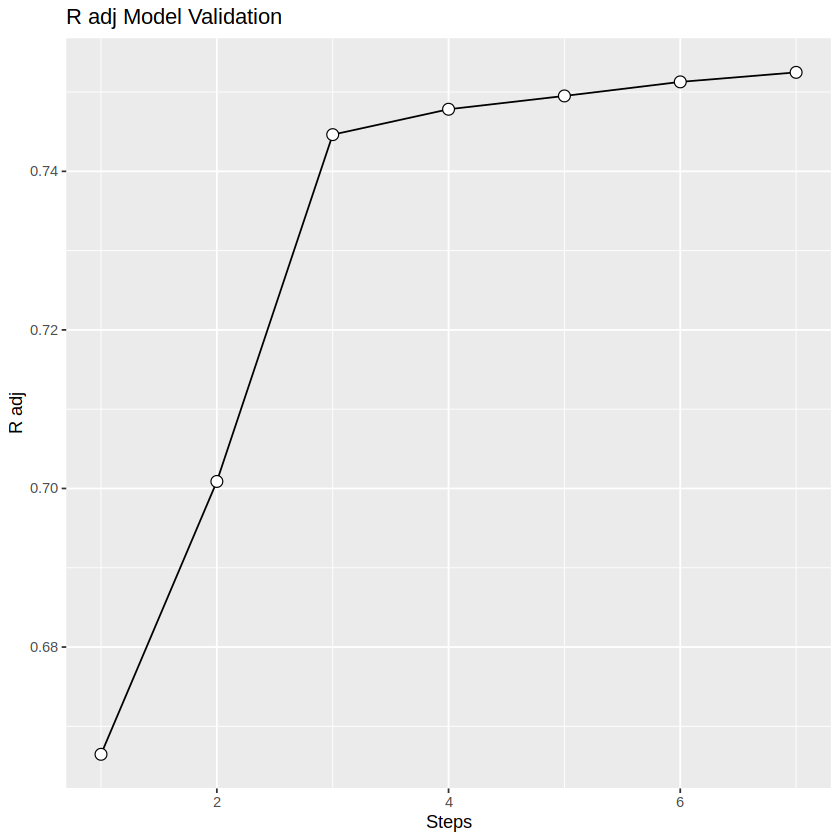

In [39]:
aic_model <- ols_step_forward_aic(model4)

# Create a dataframe for plotting
plot_data <- data.frame(Step = seq(1,aic_model$steps), adj_r = aic_model$arsq)

# Create a line plot
ggplot(plot_data, aes(x = Step, y = adj_r)) +
  geom_line() +
  geom_point(shape = 21, size = 3, fill = "white") +
  labs(x = "Steps", y = "R adj", title = "R adj Model Validation")

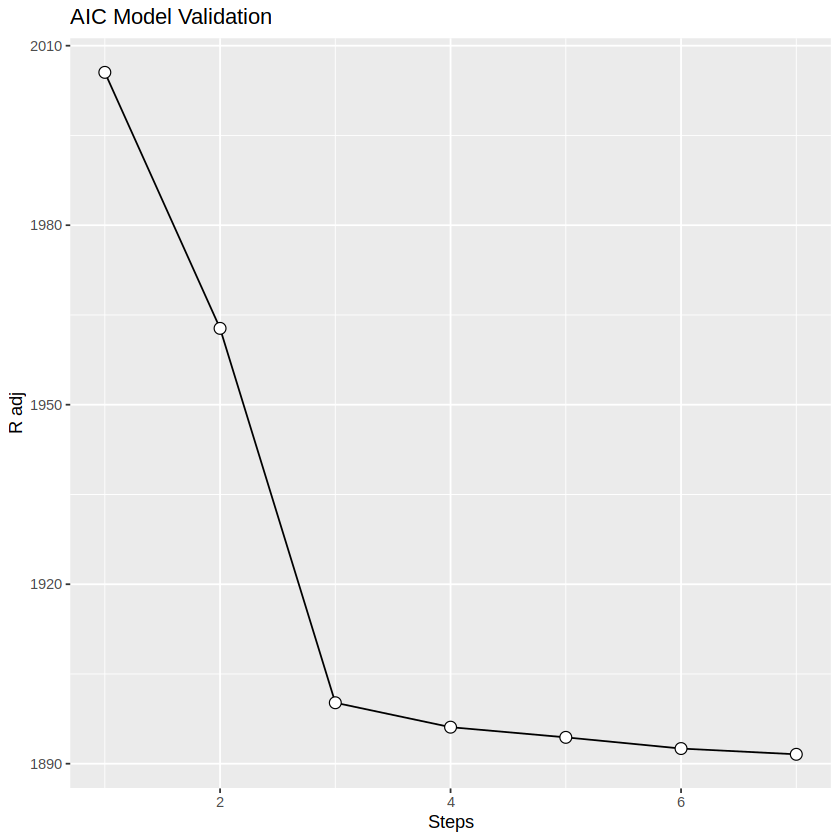

In [41]:
# Create a dataframe for plotting
plot_data <- data.frame(Step = seq(1,aic_model$steps), adj_r = aic_model$aics)

# Create a line plot
ggplot(plot_data, aes(x = Step, y = adj_r)) +
  geom_line() +
  geom_point(shape = 21, size = 3, fill = "white") +
  labs(x = "Steps", y = "R adj", title = "AIC Model Validation")

In [42]:
cat("Мнимальный AIC: ", min(aic_model$aics), "- на шаге №", which(aic_model$aics == min(aic_model$aics))[1], '\n')
cat("Максимальный скор. коэф. дет.: ", max(aic_model$arsq), '\n')
cat("Максимальный коэф. дет.: ", max(aic_model$rsq), '\n')

Мнимальный AIC:  1891.571 - на шаге № 7 
Максимальный скор. коэф. дет.:  0.7524819 
Максимальный коэф. дет.:  0.7568027 


##### Комментарии:
Лучше всего себя показала моедль из пункта 3. Скорректированные коэффициенты детерминации ухудшились в дальнейших моделях, как и информационные тесты


In [33]:


plot(ols_step_forward_p(model4)$rsquare, type='o', main="R squared")
text(num_components, ols_step_forward_p(independent_model)$rsquare, 
     labels = round(ols_step_forward_p(independent_model)$rsquare, 3), col = "red", pos = 1)

		 --- OVERWRITED plot.default 

ERROR: Error in if (class(x) == "lm") {: the condition has length > 1


In [32]:
best_model$aic

NULL

In [38]:
attributes(aic_model)
aic_model$steps

$names
[1] "predictors" "steps"      "arsq"       "aics"       "ess"       
[6] "rss"        "rsq"        "model"     

$class
[1] "ols_step_forward_aic"

[1] 7

In [ ]:
k